# Assignment 3 - Recommender Systems

The main idea to this assignment is learning and applying the concept of recommender systems. Imagine you are part of a company selling video games. You have users and you want to recommend games for these users to buy and play. For this purpose we provide to you with a dataset based on the Steam Game Store.

In [756]:
# First some imports, as always
import torch
import pandas as pd
import numpy as np
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import TruncatedSVD

In [757]:
# Here we import two datasets, that we will later combine into one

steam_user_data = pd.read_csv('steam-200k.csv')
steam_description_data = pd.read_csv('steam_games.csv')

Ok let's take a look at our **steam_user_data** dataset. Each row contains a game (**game**) that was bought and/or played (**action**) by a user (**userid**). For a game that was played we addtionally know how long the user played the game (**hours**). Generally for each entry corresponding to a bought game, we also have an entry with the *play* action, but a user could buy a game, but never play it. Then we have an entry with the *purchase* action, but not an entry with a *play*. The hour field for a *purchase* entry is always 1.

In [758]:
steam_user_data.head(5)

,userid,game,action,hours,other
0,151603712,The Elder Scrolls V Skyrim,purchase,1.0,0
1,151603712,The Elder Scrolls V Skyrim,play,273.0,0
2,151603712,Fallout 4,purchase,1.0,0
3,151603712,Fallout 4,play,87.0,0
4,151603712,Spore,purchase,1.0,0


We additionally have the **steam_description_data** set, which contains addtional information about each game. We will only need a few features from this. For example the **genre** of the game or the user-generated **popular_tags**.

In [759]:
small_steam_description_data = steam_description_data[['game', 'genre', 'game_details', 'popular_tags', 'game_description']]
small_steam_description_data.head(3)

,game,genre,game_details,popular_tags,game_description
0,DOOM,Action,"Single-player,Multi-player,Co-op,Steam Achieve...","FPS,Gore,Action,Demons,Shooter,First-Person,Gr...","About This Game Developed by id software, the..."
1,PLAYERUNKNOWN'S BATTLEGROUNDS,"Action,Adventure,Massively Multiplayer","Multi-player,Online Multi-Player,Stats","Survival,Shooter,Multiplayer,Battle Royale,PvP...",About This Game PLAYERUNKNOWN'S BATTLEGROUND...
2,BATTLETECH,"Action,Adventure,Strategy","Single-player,Multi-player,Online Multi-Player...","Mechs,Strategy,Turn-Based,Turn-Based Tactics,S...",About This Game From original BATTLETECH/Mec...


We join both datasets on the **game** attribute using pandas merge function.

In [760]:
steam_data = steam_user_data.merge(small_steam_description_data, on='game')
steam_data.head(3)

,userid,game,action,hours,other,genre,game_details,popular_tags,game_description
0,151603712,Fallout 4,purchase,1.0,0,RPG,"Single-player,Steam Achievements,Full controll...","Open World,Post-apocalyptic,Exploration,Single...","About This Game Bethesda Game Studios, the aw..."
1,151603712,Fallout 4,play,87.0,0,RPG,"Single-player,Steam Achievements,Full controll...","Open World,Post-apocalyptic,Exploration,Single...","About This Game Bethesda Game Studios, the aw..."
2,87445402,Fallout 4,purchase,1.0,0,RPG,"Single-player,Steam Achievements,Full controll...","Open World,Post-apocalyptic,Exploration,Single...","About This Game Bethesda Game Studios, the aw..."


## 1. Trivial Recommendations

So now we want to use this dataset to find out which one a users should play next. The first idea you might have is to just recommend the most popular titles. Now try to find the 10 most bought games according to our dataset. 

*Hint: Use the pandas groupby function*

*TODO: List the 10 most purchased games*

In [761]:
purchased = steam_data[steam_data['action'] == 'purchase']
sorted_purchased = purchased.groupby('game').count()['action'].sort_values(ascending=False)[:10]
sorted_purchased

game
Dota 2               4841
Team Fortress 2      2323
Unturned             1563
Left 4 Dead 2         951
Counter-Strike        856
Warframe              847
Garry's Mod           731
Robocraft             689
Heroes & Generals     658
Half-Life 2           639
Name: action, dtype: int64

Now these might be the most bought games, but not the most played games. There might be games that users buy, but not really play. Also games with a high avg playing time might mean, that users tend to like the game. Now try to find the 10 games with the longest avg playtime per user.

*Hint: Don't forget to select only the entries that contain played games*

*TODO: List the 10 games with the highest avg hours played*

In [762]:
played = steam_data[steam_data['action'] == 'play']
sorted_by_playtime = played.groupby('game')['hours'].mean().sort_values(ascending=False)[:10]
sorted_by_playtime

game
Eastside Hockey Manager     1295.000000
Perpetuum                    400.975000
Freaking Meatbags            331.000000
Counter-Strike               236.375176
Avernum 4                    228.000000
Dota 2                       202.785499
Europa Universalis IV        195.180000
Cultures - Northland         194.000000
Uncharted Waters Online      181.000000
Pro Cycling Manager 2014     177.500000
Name: hours, dtype: float64

This might actually have a slight problem. For example, WTF is 'Eastside Hockey Manager' and why does it have an average playing time of over 1000 hours. In order to migitage that some games might only be bought by very few users, that then play it a long time, let's weight the avg playtime by the percentage of users that play this game.

*TODO: Multiply each avg hours with the ratio of users playing the game and users overall!*


In [763]:
played = steam_data[steam_data['action'] == 'play']
(played.groupby('game')['hours'].mean() * (played.groupby('game')['hours'].count() / len(played['userid'].unique()))).sort_values(ascending=False)[:10]

game
Dota 2                106.082191
Team Fortress 2        18.767376
Counter-Strike         14.508440
Garry's Mod             5.373384
Left 4 Dead 2           3.630506
Terraria                3.236633
Warframe                2.925719
Arma 3                  2.599492
Grand Theft Auto V      2.480733
Borderlands 2           2.449525
Name: hours, dtype: float64

Now that should look like a pretty decent list of popular games on Steam from 4 years ago, when this dataset was collected. These lists might seem like a good starting point for a new user, but for old users we want to recommend games tat fit a user's preferences. So the first thing we can do is to look at the obvious features of the games that a user likes, e.g. genre, tags etc. and try to find similiar games with similiar features.

## 2. Content-Based Recommendation

So let us imagine we have a user that really loves the rougelite rythm dungeon crawler *Crypt of the NecroDancer* (https://store.steampowered.com/app/247080/Crypt_of_the_NecroDancer/) Your task is now (in increasingly complicated and mathy ways) to find similiar games to it. We will begin by using the Jaccard Similarity measure and the **popular_tags** feature. The user generated tags should tell us alot about what the content of the games are and just by comparing which games have simliar sets of tags should already give us a good collection of simliar games.

*TODO: Group the steam_data by game and select only the **popular_tags** for each game*

In [764]:
tag_data = steam_data.groupby('game').first()['popular_tags']

*Encode the genre feature with One-Hot-Encoding by using panda's str.get_dummies(seperator) (https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.get_dummies.html) function*


In [765]:
tag_dummies = tag_data.str.get_dummies(sep=',')
tag_dummies.head(5)

,1980s,1990's,2.5D,2D,2D Fighter,3D,3D Platformer,3D Vision,4 Player Local,4X,...,Warhammer 40K,Web Publishing,Werewolves,Western,Word Game,World War I,World War II,Wrestling,Zombies,e-sports
game,,,,,,,,,,,,,,,,,,,,,
1... 2... 3... KICK IT! (Drop That Beat Like an Ugly Baby),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10 Second Ninja,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"10,000,000",0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100% Orange Juice,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
140,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


*TODO: Calculate the pairwise jaccard distances between each game using our genre dummies using sklearn's pairwaise distance function*

*Hint: When dealing with binary data the jaccard distance (1 - jaccard simliarity) is actually equivalent to the hamming distance* 

In [766]:
# Calculate the pairwise jaccard distances between each game using our genre dummies

jac_dist = pairwise_distances(tag_dummies.values, metric = "hamming")
jac_dist

array([[0.        , 0.03370787, 0.06179775, ..., 0.06741573, 0.03932584,
        0.02808989],
       [0.03370787, 0.        , 0.05617978, ..., 0.06741573, 0.04494382,
        0.03370787],
       [0.06179775, 0.05617978, 0.        , ..., 0.09550562, 0.06179775,
        0.0505618 ],
       ...,
       [0.06741573, 0.06741573, 0.09550562, ..., 0.        , 0.07865169,
        0.06179775],
       [0.03932584, 0.04494382, 0.06179775, ..., 0.07865169, 0.        ,
        0.03932584],
       [0.02808989, 0.03370787, 0.0505618 , ..., 0.06179775, 0.03932584,
        0.        ]])

*TODO: Now write a funtion that takes an arbitrary distance matrix, a list of games that are possible, the game title we are looking for and a value k and returns the k closest games according to the distance matrix*

*Hint: Try using numpy's argsort function and don't forget to not count the queried game itself*

In [767]:
def getTopKSimiliarGames(distances: np.array, games: list, game: str, k: int):
    game_index = games.index(game)
    distances_to_game = distances[game_index]
    topk_indeces = np.argsort(distances_to_game)[1:k+1]
    return [(games[i], distances_to_game[i]) for i in topk_indeces]

Now let's use your function to find the top-10 most simliar games to 'Crypt of the NecroDancer'

In [768]:
getTopKSimiliarGames(jac_dist, list(tag_data.index), 'Crypt of the NecroDancer', 10)

[('Diehard Dungeon', 0.02247191011235955),
 ("A Wizard's Lizard", 0.025280898876404494),
 ('Deep Dungeons of Doom', 0.03089887640449438),
 ('Dungeon Siege III', 0.033707865168539325),
 ('bit Dungeon II', 0.033707865168539325),
 ('Legend of Dungeon', 0.033707865168539325),
 ('Crawl', 0.033707865168539325),
 ('Castle In The Darkness', 0.033707865168539325),
 ('Tiny Barbarian DX', 0.033707865168539325),
 ('Ascendant', 0.03651685393258427)]

Now that already looks like a decent list of recommendations for someone who likes Dungeon Crawlers. But if we look at a user we actually know more than just one game they like. We need a way to combine the features of multiple games into a single query, so that we find the games that are most simliar to the ones the user likes.

We can combine the recommendations for several games (the ones a user played) by using TF/IDF and Cosine Distance. TF is the term frequency, which in this case means how often a tag is included in the games that a single user plays and it is compared with the IDF. IDF is the Indirect Document Frequency and in our case this is the count of all tag over all documents divided by the occurance of a single tag in all documents.

*TODO: Use the tag_dummies table to calculate the inverse Document Frequency for each tag using the follwing function, with N being the number of games and n_t being the occurence of a the queried tag overall documents:*
$$ \log_{10}\frac{N}{n_t}$$

In [770]:
tag_idfs = np.log10(tag_dummies.shape[0] / tag_dummies.sum())
tag_idfs

1980s           2.181844
1990's          1.642574
2.5D            1.953364
2D              0.649383
2D Fighter      1.973568
                  ...   
World War I     2.295787
World War II    1.662318
Wrestling       3.295787
Zombies         1.242708
e-sports        2.254394
Length: 356, dtype: float64

*TODO: Replace all the 1 entries in the tag_dummies table with the corresponding idf value, resulting in a new vector space for our games*

*Hint: Try multiplying each column with the corresponding value*

In [771]:
tag_idf_embedding = pd.DataFrame()
for column in tag_dummies.columns:
    tag_idf_embedding[column] = tag_dummies[column] * tag_idfs[column]

Then let's calculate the pairwise cosine distances and apply our topk function again.

In [772]:
idf_distances = pairwise_distances(tag_idf_embedding.values, metric = "cosine")

In [773]:
getTopKSimiliarGames(idf_distances, list(tag_data.index), 'Crypt of the NecroDancer', 10)

[('Diehard Dungeon', 0.32188027975279354),
 ('Deep Dungeons of Doom', 0.36448485968451605),
 ("A Wizard's Lizard", 0.38333384250021185),
 ('Rampage Knights', 0.45030010253811026),
 ('BIT.TRIP VOID', 0.45404226539552106),
 ('Legend of Dungeon', 0.4545797533373491),
 ('Pixel Boy and the Ever Expanding Dungeon', 0.4735571923201467),
 ('BeatBlasters III', 0.48205717807825044),
 ('bit Dungeon II', 0.4889300462429047),
 ('Desktop Dungeons', 0.4946704027114871)]

Interestingly enough, now you should see that a few Rythm Style games have found their way into the top 10. NecroDancer is a rougelike dungeon crawler and a rythm game. So  there are less rythm games than dungeon crawlers on steam and therefore the tags that concern the rythm part of the game are weighted more than the dungeon tags. And that is excactly the idea behind idf! We want to lessen the importance of more frequently used words, e.g. in language this would mean that words like 'the' and 'and' are explicitly embedded as less important than very words that are specific to a document. 

## 3. Collaborative Filtering

What we did up till now is often refered to as *Content-Based Recommendation*. This means we use the features of the items that a user likes or has interacted with (in this case video games) to find similiar items that this user might like. That means we do not use information about other user than the target. What we can also do is use the preferences of other users to recommend games to our target user.

And that is what *Collaborative Filtering* Recommender Systems try to do. In our case the information about games based upon other users is encoded in the **action** feature. We can look at this feature as a sort of user rating of a game. We assume that if someone bought a game they found it interesting enough and if they then played it a lot they they even liked the game. From this we want to create a matrix. 

*TODO: First create a ratings matrix that has a 1 if a user bought a game and a 0 if they did not buy it.* 

*Hint: Use the pandas function pivot_table (https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.pivot_table.html)*

In [659]:
purchased = steam_data[steam_data['action'] == 'purchase']
ratings_table = purchased.pivot_table(index='userid', columns='game', values='hours', fill_value=0)
ratings_table

game,1... 2... 3... KICK IT! (Drop That Beat Like an Ugly Baby),10 Second Ninja,"10,000,000",100% Orange Juice,140,16bit Trader,1954 Alcatraz,3 Stars of Destiny,3DMark,3DMark 11,...,iRacing,ibb & obb,in Space,oO,planetarian ~the reverie of a little planet~,rFactor,rFactor 2,resident evil 4 / biohazard 4,rymdkapsel,samurai_jazz
userid,,,,,,,,,,,,,,,,,,,,,
5250,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
76767,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
86540,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
103360,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
144736,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309404240,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
309434439,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
309812026,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Another possibility would be to user the played hours as a rating, for example by fitting a histogram with 5 buckets (or even a mixture of gaussians with 5 functions) to the **hours** feature and using this as a rating vom 1 - 5 'stars'. This is also completely reasonable and if you want you can try it out, but we will continue with the purchase information + confidence model.

Let us take a closer look at our ratings matrix. What attributes can we gather from it?

*TODO: Calculate the percentage of 1 entries in the matrix*

In [662]:
sparsity = ratings_table.sum().sum() / ratings_table.count().sum() * 100
print('{:.2%} of the user-item matrix is filled'.format(sparsity))

28.02% of the user-item matrix is filled


As you can see most of our table is empty. This means our matrix is very sparse! Which makes sense since this is in the title of your Assigment ;).

In [660]:
# From now on we will use numpy instead of pandas, because some calculations 
# are easier done with numpy arrays instead of DataFrames
# Here is how to convert a pandas df to a numpy array
ratings_matrix = ratings_table.values
# Well that was easy:
ratings_matrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

### 3.1 Trivial Calculations

Right now our matrix has a row for each users showing us, but if we transpose our matrix, we now have new features for each of our games. And we can use the resulting feature space to find simliar games again.

In [666]:
# use sklear pairwise distance to calculte the cosine distances 
trivial_cos_distances = pairwise_distances(ratings_matrix.T, metric='hamming')

In [667]:
trivial_cos_distances

array([[0.        , 0.00128205, 0.00078895, ..., 0.00285996, 0.00078895,
        0.00078895],
       [0.00128205, 0.        , 0.00069034, ..., 0.00276134, 0.00069034,
        0.00069034],
       [0.00078895, 0.00069034, 0.        , ..., 0.00246548, 0.00019724,
        0.00019724],
       ...,
       [0.00285996, 0.00276134, 0.00246548, ..., 0.        , 0.00246548,
        0.00246548],
       [0.00078895, 0.00069034, 0.00019724, ..., 0.00246548, 0.        ,
        0.00019724],
       [0.00078895, 0.00069034, 0.00019724, ..., 0.00246548, 0.00019724,
        0.        ]])

Now again let's Use your getTopKSimiliarGames function to find the 10 most similiar games to Crypt.

In [ ]:
getTopKSimiliarGames(trivial_cos_distances, list(ratings_table.columns), 'Crypt of the NecroDancer', 10)

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

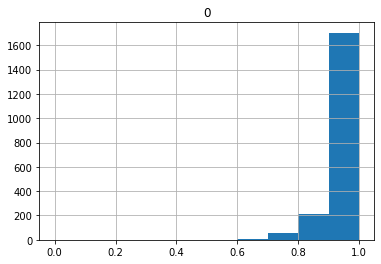

In [664]:
# Well that's actually not the worst result. Let's look at the distribution  
# our distances

game_index = list(ratings_table.columns).index('Crypt of the NecroDancer')
distances_to_game = trivial_cos_distances[game_index]

pd.DataFrame(distances_to_game).hist()

As you can see these distances are not distributed well. Which is excactly the problem with such sparse vector spaces. And if you listened to the lecture you might know what this calls for. Dimensionality Reduction with ...

### 3.2 SVD

So we can assume that there is some underlying factors that lead to users buying certain games. We do not know these attributes and therefore they are often refered to as *hidden features*, *latent features* or *embeddings*. We can assume that this latent space has a significantly lower dimensionality than our ratings_matrix. One way to find these features is to use the Matrix Factorization to create two low dimensional matrices that multiply to our ratings matrix. This can be seen as a kind of compression. One classic MF is SVD. In this case we want to reduce the dimensionality so we use truncated svd.

*TODO: Use sklearn.decomposition.TruncatedSVD (https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html) to create a new lower rank matrix. Start by using a high number of components (ca. 100) and look at the explained variance ratio. Use this information to find a reasonable number of dimensions after which the variance ratio drops below 0.01. The TruncatedSVD Functions is sometimes a bit unstable. If you get a weird error, just run the cell again until it runs through*

In [673]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=11)
usv = svd.fit_transform(ratings_matrix.T)
print(svd.explained_variance_ratio_)

[0.12426155 0.07207986 0.04747838 0.04038503 0.02679706 0.01660196
 0.01614743 0.01312306 0.0109225  0.01053031 0.01053991]


In [678]:
usv

array([[ 3.16284377e-01, -1.92607138e-01, -9.05829057e-02, ...,
        -7.14908998e-02,  1.35323515e-01, -2.76706741e-01],
       [ 2.62529085e-01, -1.95470486e-01, -1.10153166e-01, ...,
        -2.24229288e-02, -7.72515663e-02, -2.03842869e-02],
       [ 7.50783955e-02, -6.68062379e-02, -7.67320770e-02, ...,
         4.65566131e-02, -3.13007565e-02, -7.02849581e-03],
       ...,
       [ 9.38416579e-01, -7.54330874e-01, -4.57621690e-01, ...,
         2.47663902e-01, -2.31961327e-01,  4.18070146e-01],
       [ 1.46920462e-03, -1.99504034e-03, -1.92755001e-03, ...,
        -6.07213630e-03, -7.43538553e-04,  4.71129459e-03],
       [ 8.39701086e-03,  1.33156532e-02,  2.67708351e-03, ...,
        -1.33714421e-02, -1.93585892e-02, -8.75043394e-03]])

*TODO: Use pairwise cosine distance on the reduced game vectors*

In [282]:
svd_cos_distances = pairwise_distances(usv, metric='cosine')

And we run our function to search similiar games to 'Crypt of the Necrodancer' again

In [675]:
getTopKSimiliarGames(svd_cos_distances, list(ratings_table.columns), 'Crypt of the NecroDancer', 10)

[('Rogue Legacy', 0.034317738660559205),
 ('Epic Battle Fantasy 4', 0.03907860894752979),
 ('Keep Talking and Nobody Explodes', 0.050460652459689115),
 ('SOMA', 0.051270176741117),
 ('Grow Home', 0.051315085592052334),
 ('Damned', 0.0518769307268927),
 ('Broforce', 0.05785105786061573),
 ('Super Time Force Ultra', 0.06265348234538015),
 ('Axiom Verge', 0.06423582490488633),
 ('Cannon Brawl', 0.06515340982124918)]

And now you might see that this not as easily comprehensible than using the explicit tag feature. As already stated we do not know what leads to the buying habits of the users, so we have to trust that there is some hidden relation between these games. But we can look at the distance distribution again to see whether our latent space is useful and it looks much better this time. There are some games very close to our target, some that are very far away, but most 

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

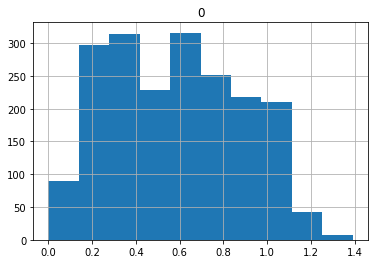

In [676]:
game_index = list(ratings_table.columns).index('Crypt of the NecroDancer')
distances_to_game = svd_cos_distances[game_index]

pd.DataFrame(distances_to_game).hist()

Now let's combine both the text features and the user features to find the best games for our test users again!

*TODO: First we need to make sure that both our distances are in the same value range. So use sklearn.preprocessing.normalize to norm both svd_cos_distances and idf_distances to [0, 1] and then take the mean of each value in both lists*

In [685]:
from sklearn.preprocessing import normalize

combined_distances = normalize(svd_cos_distances) + normalize(idf_distances)/ 2

And another call to our function:

In [686]:
getTopKSimiliarGames(combined_distances, list(ratings_table.columns), 'Crypt of the NecroDancer', 10)

[('BIT.TRIP VOID', 0.006370129494176643),
 ('Diehard Dungeon', 0.008968084112471183),
 ("A Wizard's Lizard", 0.009302838126073291),
 ('Sentris', 0.00930948003965029),
 ('Rogue Legacy', 0.009567555301166904),
 ('Spelunky', 0.010663771576159196),
 ('The Binding of Isaac', 0.010853068903671466),
 ('Chime', 0.0112714881584805),
 ('Legend of Dungeon', 0.011303505601184954),
 ('Invisible, Inc.', 0.011344441482770942)]

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

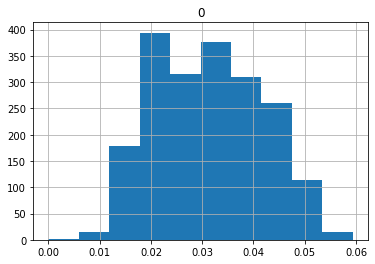

In [689]:
game_index = list(ratings_table.columns).index('Crypt of the NecroDancer')
distances_to_game = combined_distances[game_index]

pd.DataFrame(distances_to_game).hist()

Now this actually looks like a very good collection of games for some one who likes Crypt of the NecroDancer. 
We did our job and we could stop here, but it is always good to try a lot of different approaches and models. Also we still have not actually recommened games tailored to a sngle user. We could now use the svd matrix to reconstruct our original matrix and check whether we get some new entries for users, but since the results from svd actually allow for negative matrix entrices in the Factor Matrices we did not really learn anything. There are way more Facorizations with negative values, than if we restrict our factor matrices to be Non Negative. And that is our last step:  

### 3.3 Non Negative Matrix Factorization

So SVD is nice enough, but there is other ways to find good latent features for our games, and thereby hopefully make even better recommendations. If you want you can also try out CUR, but we will end this assignment by doing Non Negative Matrix Factorization using numpy. Finally some actual Machine Learning!

*TODO: Using only numpy and Two Block Coordinate Descent: Given the ratings matrix $X \in \mathbb{R}_+^{n \times d}$ and a latent dimensionality $k$, find two non-negative matrices $W \in \mathbb{R}_+^{n \times k}$ and $H \in \mathbb{R}_+^{k \times d}$ such that $X - WH$ minimizes the Frobenius Norm (Basically another term for the euclidean distance, just as a matrix norm, https://mathworld.wolfram.com/FrobeniusNorm.html). You are given the algorithm and the update formulars for both matrices. Hint: @ is the short hand for matrix multiplication with numpy. For example W @ H*

#### Two Block Coordinate Descent

1. Init $W^{(0)} \geq 0$ and $H^{(0)} \geq 0$
2. For t in 1...epochs:
3. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$W^{(t)} = \text{update}(X, H^{(t-1)}, W^{(t-1)})$
4. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$H^{(t)} = \text{update}(X, W^{(t)}, H^{(t-1)})$
5. End For


 * **Loss Function** $$ L(W, H) = \frac{1}{2} || X - WH ||_F^2 $$
 ---
 * **Update Rule for W**: $$ W \leftarrow W \times \frac{XH^T}{WHH^T} $$
 ---
 * **Update Rule for H**: $$ H \leftarrow H \times \frac{W^TX}{W^TWH} $$

*TODO Step 1: Initialize $W$ and $H$*

In [739]:
embedding_dim = 11
X = ratings_matrix
W = np.random.rand(X.shape[0], embedding_dim)
H = np.random.rand(embedding_dim, X.shape[1])

*TODO Step 2: Define the Loss function (Frobenius norm)*

In [775]:
loss = lambda X, WH: 0.5 * np.sqrt(((X - (WH))**2)).mean()

In [741]:
# Just a list to collect the losses for each epoch
losses = []

*TODO: Step 3: Here you have an emtpy loop for your 2-Block Coord Descent.*

*Hint: Make sure that $W$ and $H$ do not contain actual zero values or values that are so low that they create an integer underflow, for example by using numpy's where function!*

In [742]:
from tqdm.notebook import tqdm

epochs = 50
lr = 10e-4
for e in tqdm(range(epochs)):
    W = np.where(W < 10e-10, 10e-10, W)
    H = np.where(H < 10e-10, 10e-10, H)
    
    W = W * ((X @ H.T)/(W @ H @ H.T))
    H = H * ((W.T @ X)/(W.T @ W @ H))
    
    WH = W @ H
    single_loss = loss(X, WH)
    
    if e % 10 == 0:
        print(f'Epoch: {e}, Loss: {single_loss}')
    
    losses.append(single_loss)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0, Loss: 50351.2385657312
Epoch: 10, Loss: 46593.7660969123
Epoch: 20, Loss: 42992.734692195365
Epoch: 30, Loss: 41702.52335942986
Epoch: 40, Loss: 41312.70582327237


Ok, let's take a look at our losses. It should start high, shortly go higher and then go straight done until it does not really change anymore:

<AxesSubplot:>

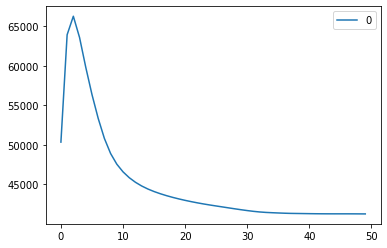

In [776]:
pd.DataFrame(losses).plot()

Your final loss after 100 epochs should be about ...

In [ ]:
loss(X, W @ H)

Now we reconstruct X

In [706]:
X_pred = W @ H

*TODO: Create a new ratings matrix by replacing each value lower than 0.1 by a 0 and each other value with a 1. Hint: Use numpy's where function*

In [614]:
new_ratings = np.where(X_pred < 0.1, 0, 1)

In [615]:
new_ratings

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

Now we can make a new ratings table

In [618]:
new_ratings_table = pd.DataFrame(new_ratings, index=ratings_table.index, columns=ratings_table.columns)

Let us pick a user and check out what we would recommend to them:

In [725]:
old_games = steam_data[steam_data['userid'] == 5250]['game']
new_recommendations = new_ratings_table.iloc[0][new_ratings_table.iloc[0] == 1].index

This is what this user purchased before:

In [726]:
set(old_games)

{'Alien Swarm',
 'Counter-Strike',
 'Day of Defeat',
 'Deathmatch Classic',
 'Dota 2',
 'Half-Life',
 'Half-Life 2',
 'Portal',
 'Portal 2',
 'Ricochet',
 'Team Fortress 2',
 'Team Fortress Classic'}

And here are the games that are new, i.e. the ones that we recommend to this user:

In [723]:
set(new_recommendations) - set(old_games)

{'BioShock Infinite', 'Borderlands 2', 'Left 4 Dead', 'Left 4 Dead 2'}

Ok now you yourself can decide whether those are some good recommendations or not :P And that's it for this Assignment. I hope it was interesting and fun :)